In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib as mpl

import numpy as np
import pandas as pd
import pickle as pkl

from scipy.stats import lognorm
from scipy.stats import norm

In [2]:
# Defaults used for ESSD paper

SMALL_SIZE = 8
MEDIUM_SIZE = 8
BIGGER_SIZE = 10
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('text', usetex=False)             #
plt.rcParams['figure.dpi'] = 100         # Display dpi
plt.rcParams['savefig.dpi'] = 300        # Save dpi
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.pad_inches'] = 0
plt.rcParams["axes.titlepad"] = 3.0

Important functions

In [3]:
def r_trans(y):
    y = np.asarray(y)
    return np.exp(((y - a) * (obs_log_max -  obs_log_min) / (b - a)) + obs_log_min)

def reverse_transform_std(y):
    return ((y)*(obs_log_max - obs_log_min) / (b - a))

def recube(in_array):

    plev_len = 52
    lat_len = 36
    time_len = 31 * 12

    output = np.zeros([time_len, plev_len, lat_len])

    for t in range(time_len):
        output[t,:,:] = in_array[plev_len * lat_len * (t): plev_len * lat_len * (t+1)].reshape([plev_len, lat_len])
    
    return output

def interp_to_new_lats(psp, old_lats):
    
    new_lats = lat
    
    interp_psp = []
    for t in range(372):
        interp_psp.append(np.interp(new_lats, old_lats, psp[t]))
    return np.array(interp_psp)
        

In [4]:
from matplotlib.image import imread
from tempfile import NamedTemporaryFile

def get_size(fig, dpi=100):
    with NamedTemporaryFile(suffix='.png') as f:
        fig.savefig(f.name, bbox_inches='tight', dpi=dpi)
        height, width, _channels = imread(f.name).shape
        return width / dpi, height / dpi

def set_size(fig, size, dpi=100, eps=1e-2, give_up=2, min_size_px=10):
    target_width, target_height = size
    set_width, set_height = target_width, target_height # reasonable starting point
    deltas = [] # how far we have
    while True:
        fig.set_size_inches([set_width, set_height])
        actual_width, actual_height = get_size(fig, dpi=dpi)
        set_width *= target_width / actual_width
        set_height *= target_height / actual_height
        deltas.append(abs(actual_width - target_width) + abs(actual_height - target_height))
        if deltas[-1] < eps:
            return True
        if len(deltas) > give_up and sorted(deltas[-give_up:]) == deltas[-give_up:]:
            return False
        if set_width * dpi < min_size_px or set_height * dpi < min_size_px:
            return False

Load data

In [5]:
in_dir = './../BNNOutput/'
lat = pkl.load(open(in_dir + 'lats.pkl', 'rb'))
plev = np.unique(pkl.load(open(in_dir + 'plevs.pkl', 'rb'))/100)[::-1]
date = pkl.load(open(in_dir + 'dates.pkl', 'rb'))

num_models = 13
df = pd.read_pickle('./../vmro3_refC1SD_70x36_13mdls_masked_extrap_and_interp.pkl')
plev_orig = np.unique(df['plev'])[::-1]
df = df[df['plev'] < 50000]
df = df[df['plev'] > 30]
obs = df['obs_toz'].copy()
obs[np.log10(obs) < -9] = np.nan
df['obs_toz'] = obs

obs = recube(df['obs_toz'].values)
train_mask = recube(df['train'].values).astype(np.bool)
test_mask = recube(df['test'].values).astype(np.bool)
interp_mask = recube(df['temp_interp'].values).astype(np.bool)
extrap_mask = recube(df['temp_extrap'].values).astype(np.bool)

obs_train = obs.copy()
obs_train[~train_mask] = np.nan
obs_test = obs.copy()
obs_test[~test_mask] = np.nan
obs_interp = obs.copy()
obs_interp[~interp_mask] = np.nan
obs_extrap = obs.copy()
obs_extrap[~extrap_mask] = np.nan

obs_min = df['obs_toz'].min()
obs_max = df['obs_toz'].max()

obs_log_max = np.log(obs_max)
obs_log_min = np.log(obs_min)
a, b = [-1, 1]

# ptp = pkl.load(open('mon_trpp_1980-2010.pkl', 'rb'))
# psp = pkl.load(open('ave_CCMI_psp.pkl', 'rb')) / 100    # psp is in Pa
# ptp = interp_to_new_lats(ptp, np.arange(-90,90.1, 180/72))    # ptp needs regridding

# BNN output
weights = pkl.load(open(in_dir + 'weights.pkl', 'rb'))
bias_raw = pkl.load(open(in_dir + 'bias.pkl', 'rb')) 
noise_raw = pkl.load(open(in_dir + 'noise.pkl', 'rb')) 
std_raw = recube(pkl.load(open(in_dir + 'std.pkl', 'rb')))
pred_raw = recube(pkl.load(open(in_dir + 'pred.pkl', 'rb')))
epi_raw = pkl.load(open(in_dir + 'epi.pkl', 'rb'))

train_data_count = []
for i in range(372):
    train_data_count.append(np.sum(df['train'][df['mons']==i + 1]))
train_data_count = np.array(train_data_count)


/opt/miniconda3/envs/bnn-env/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  app.launch_new_instance()
/opt/miniconda3/envs/bnn-env/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/opt/miniconda3/envs/bnn-env/lib/python3.7/site-packages/ipykernel_l

# Rescale raw data back to 'real' values

In [6]:
# Find the bounds of prediction ±1,2,3 std then convert to real values
p1plus = r_trans(pred_raw + std_raw)
p2plus = r_trans(pred_raw + 2 * std_raw)
p3plus = r_trans(pred_raw + 3 * std_raw)
p1minus = r_trans(pred_raw - std_raw)
p2minus = r_trans(pred_raw - 2 * std_raw)
p3minus = r_trans(pred_raw - 3 * std_raw)
pred = r_trans(pred_raw)

# This is also done for noise
p1plusn = r_trans(pred_raw + noise_raw)
p2plusn = r_trans(pred_raw + 2 * noise_raw)
p3plusn = r_trans(pred_raw + 3 * noise_raw)
p1minusn = r_trans(pred_raw - noise_raw)
p2minusn = r_trans(pred_raw - 2 * noise_raw)
p3minusn = r_trans(pred_raw - 3 * noise_raw)

# and epistemic uncertainty
p1pluse = r_trans(pred_raw + epi_raw)
p2pluse = r_trans(pred_raw + 2 * epi_raw)
p3pluse = r_trans(pred_raw + 3 * epi_raw)
p1minuse = r_trans(pred_raw - epi_raw)
p2minuse = r_trans(pred_raw - 2 * epi_raw)
p3minuse = r_trans(pred_raw - 3 * epi_raw)

# These values are estimates of std, noise and epi. 
# They are only estimates as the distribution is asymmetric
std1sigma = (p1plus - p1minus) / 2
std2sigma = (p2plus - p2minus) / 2
std3sigma = (p3plus - p3minus) / 2

noise1sigma = (p1plusn - p1minusn) / 2
noise2sigma = (p2plusn - p2minusn) / 2
noise3sigma = (p3plusn - p3minusn) / 2

# Epistemic uncertainty could also be found by descaling all the
# individual predictions and finding the std across them
epi1sigma = (p1pluse - p1minuse) / 2
epi2sigma = (p2pluse - p2minuse) / 2
epi3sigma = (p3pluse - p3minuse) / 2

In [7]:
# Custom colours
cr2 = '#f37651'
cr4 = '#ad1759'
cb3 = '#4d8ca6'
cr3 = '#e13342'
cr6 = '#35193e'

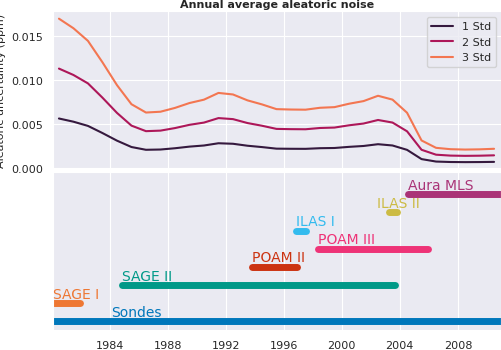

In [8]:
with plt.rc_context(dict(sns.axes_style("darkgrid"))):
    colors = ['#0077BB',
              '#EE7733',
              '#009988',
              '#CC3311',
              '#EE3377',
              '#33BBEE',
              '#CCBB44',
              '#AA3377'
              
]
    fig = plt.figure()
    plt.subplot(2, 1, 1)
    plt.plot(date[5::12], np.mean(np.mean(noise1sigma, axis=(1,2)).reshape(31,12), axis=1) / 1e-6, label='1 Std', color=cr6)
    plt.plot(date[5::12], np.mean(np.mean(noise2sigma, axis=(1,2)).reshape(31,12), axis=1) / 1e-6, label='2 Std', color=cr4)
    plt.plot(date[5::12], np.mean(np.mean(noise3sigma, axis=(1,2)).reshape(31,12), axis=1) / 1e-6, label='3 Std', color=cr2)
    plt.title('Annual average aleatoric noise', fontweight='heavy')
#     plt.ylim([0, 2.5e-2])
#     plt.gca().set_xticklabels([])
    plt.ylabel('Aleatoric uncertainty (ppm)')
    plt.xlim([date[0], date[-1]])
    plt.legend()
    
    
    plt.subplot(2,1,2)
    plt.plot([date[0], date[-1]], [1,1], label='Sondes', lw=5, color=colors[0])
    plt.annotate('Sondes', [date[48], 1.5], va='center', color=colors[0], size=10)
    plt.plot([date[0], date[22]], [2,2], label='SAGE I', lw=5, color=colors[1])
    plt.annotate('SAGE I', [date[0], 2.5], va='center', color=colors[1], size=10)
    plt.plot([date[57], date[283]], [3,3], label='SAGE II', lw=5, color=colors[2])
    plt.annotate('SAGE II', [date[57], 3.5], va='center', color=colors[2], size=10)
    plt.plot([date[165], date[202]], [4,4], label='POAM II', lw=5, color=colors[3])
    plt.annotate('POAM II', [date[165], 4.5], va='center', color=colors[3], size=10)
    plt.plot([date[219], date[310]], [5,5], label='POAM III', lw=5, color=colors[4])
    plt.annotate('POAM III', [date[219], 5.5], va='center', color=colors[4], size=10)
    plt.plot([date[201], date[209]], [6,6], label='ILAS I', lw=5, color=colors[5])
    plt.annotate('ILAS I', [date[201], 6.5], va='center', color=colors[5], size=10)
    plt.plot([date[278], date[285]], [7,7], label='ILAS II', lw=5, color=colors[6])
    plt.annotate('ILAS II', [date[268], 7.5], va='center', color=colors[6], size=10)
    plt.plot([date[294], date[-1]], [8,8], label='Aura MLS', lw=5, color=colors[7])
    plt.annotate('Aura MLS', [date[294], 8.5], va='center', color=colors[7], size=10)
    
    plt.xlim([date[0], date[-1]])
    plt.ylim([0.5, 9.2])
    plt.yticks([])
    
    plt.subplots_adjust(bottom=0., right=1., top=1., left=0., hspace=0.02)
    set_size(fig, (5, 3.5))
    plt.savefig('./../figures/paper3-ann_ave_ale_noise.pdf', bbox_inches='tight', dpi=200)
    plt.savefig('./../figures/paper3-ann_ave_ale_noise.png', bbox_inches='tight', dpi=200)


# Table of performance

RMSE - for train

In [9]:
np.sqrt(np.nanmean((obs.ravel()[df['train'].values] - pred.ravel()[df['train'].values]) ** 2))

1.425580778290948e-07

In [10]:
np.sqrt(np.nanmean((obs.ravel()[df['test'].values] - pred.ravel()[df['test'].values]) ** 2))

1.4570747299537183e-07

In [11]:
np.sqrt(np.nanmean((obs.ravel()[df['temp_interp'].values] - pred.ravel()[df['temp_interp'].values]) ** 2))

1.7037207689548431e-07

In [12]:
np.sqrt(np.nanmean((obs.ravel()[df['temp_extrap'].values] - pred.ravel()[df['temp_extrap'].values]) ** 2))

1.1255950326433668e-07

In [13]:
np.nanmean((obs.ravel()[df['train'].values] - pred.ravel()[df['train'].values]) / obs.ravel()[df['train'].values])

-0.011910605344473935

In [14]:
np.nanmean((obs.ravel()[df['test'].values] - pred.ravel()[df['test'].values]) / obs.ravel()[df['test'].values])

-0.014750058829631579

In [15]:
np.nanmean((obs.ravel()[df['temp_extrap'].values] - pred.ravel()[df['temp_extrap'].values]) / obs.ravel()[df['temp_extrap'].values])

-0.014694802668360318

In [16]:
np.nanmean((obs.ravel()[df['temp_interp'].values] - pred.ravel()[df['temp_interp'].values]) / obs.ravel()[df['temp_interp'].values])

-0.009394511584110005

In [17]:
np.nanmean((obs.ravel()[df['temp_interp'].values] - pred.ravel()[df['temp_interp'].values]))

-6.05488931544844e-09

For train

In [18]:
mask_ = df['train'].values
print(np.sum(np.logical_and(p1plus.ravel()[mask_] > obs.ravel()[mask_], p1minus.ravel()[mask_] < obs.ravel()[mask_])) / np.sum(mask_))
print(np.sum(np.logical_and(p2plus.ravel()[mask_] > obs.ravel()[mask_], p2minus.ravel()[mask_] < obs.ravel()[mask_])) / np.sum(mask_))
print(np.sum(np.logical_and(p3plus.ravel()[mask_] > obs.ravel()[mask_], p3minus.ravel()[mask_] < obs.ravel()[mask_])) / np.sum(mask_))

0.8027539273327013
0.9777784474775757
0.9960932149060563


For testing

In [19]:
mask_ = df['test'].values
print(np.sum(np.logical_and(p1plus.ravel()[mask_] > obs.ravel()[mask_], p1minus.ravel()[mask_] < obs.ravel()[mask_])) / np.sum(mask_))
print(np.sum(np.logical_and(p2plus.ravel()[mask_] > obs.ravel()[mask_], p2minus.ravel()[mask_] < obs.ravel()[mask_])) / np.sum(mask_))
print(np.sum(np.logical_and(p3plus.ravel()[mask_] > obs.ravel()[mask_], p3minus.ravel()[mask_] < obs.ravel()[mask_])) / np.sum(mask_))

0.7916104946593384
0.9742818624909261
0.9947630405475475


For extrap

In [20]:
mask_ = df['temp_extrap'].values
print(np.sum(np.logical_and(p1plus.ravel()[mask_] > obs.ravel()[mask_], p1minus.ravel()[mask_] < obs.ravel()[mask_])) / np.sum(mask_))
print(np.sum(np.logical_and(p2plus.ravel()[mask_] > obs.ravel()[mask_], p2minus.ravel()[mask_] < obs.ravel()[mask_])) / np.sum(mask_))
print(np.sum(np.logical_and(p3plus.ravel()[mask_] > obs.ravel()[mask_], p3minus.ravel()[mask_] < obs.ravel()[mask_])) / np.sum(mask_))

0.7760770975056689
0.9740896358543417
0.9952314259036948


For interp

In [21]:
mask_ = df['temp_interp'].values
print(np.sum(np.logical_and(p1plus.ravel()[mask_] > obs.ravel()[mask_], p1minus.ravel()[mask_] < obs.ravel()[mask_])) / np.sum(mask_))
print(np.sum(np.logical_and(p2plus.ravel()[mask_] > obs.ravel()[mask_], p2minus.ravel()[mask_] < obs.ravel()[mask_])) / np.sum(mask_))
print(np.sum(np.logical_and(p3plus.ravel()[mask_] > obs.ravel()[mask_], p3minus.ravel()[mask_] < obs.ravel()[mask_])) / np.sum(mask_))

0.7098572345203722
0.946944177093359
0.9904956689124158


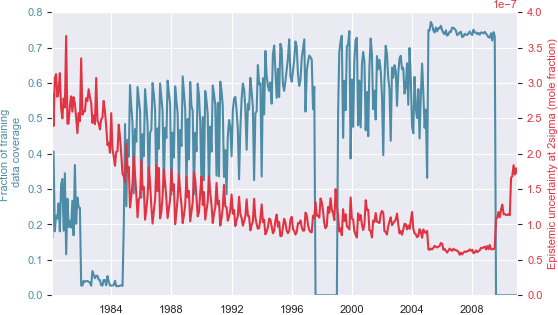

In [22]:
with plt.rc_context(dict(sns.axes_style("darkgrid"))):
    plt.figure(figsize=(6,3.75))
    ax = plt.gca()
    ax2 = ax.twinx()
    ax2.grid(False)

    ax.plot(date, train_data_count/(36 * 60), color=cb3, zorder=10)
    ax2.plot(date, np.mean(epi2sigma, axis=(1,2)), color=cr3)

    ax.tick_params(axis='y', labelcolor=cb3)
    ax2.tick_params(axis='y', labelcolor=cr3)

    ax.set_ylabel('Fraction of training \n data coverage', color=cb3)
    ax2.set_ylabel('Epistemic uncertainty at 2sigma (mole fraction)', color=cr3)

    ax.set_ylim([0, 0.8])
    ax2.set_ylim([0, 4e-7])

    plt.xlim([date[0], date[-1]])
    plt.show()